# Import Packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from os.path import exists
import os

# Functions

In [2]:
#reads outfiles without me having to remember the parameters we want to use
def load(outfile):
    data = pd.read_csv(outfile,header=26,delim_whitespace=True)
    return data

#this is Kurtis' fastSlow
#aka the effusion equation
#to be used with scipy.curve_fit; it will find the correct parameters
def eff(t,C,t1,t2):
    eff = C*(1-np.exp(-t/t1))*np.exp(-t/t2)
    return eff
#this is a different equation that I sometimes used to try to fit the effusion curves
#Never panned out, but the equation is solid (also used in RIBO prelim fits)
def slow_eff(t,C,t1,t2):
    eff = C*np.exp(-t/t1)/t1
    return eff
#this is Kurtis' plotHistogram
def plot_hist(data,                   #list or sim. (from outfile)
              label=None,             #for plot legend
              col='#000000',          #for plot line/scatter
              mark=True,              #include scatter
              norm=False,             #normalize by number of counts
              lin=10000,              #number of 'bins' for line (large for smooth curve)
              bbin=50,                #number of bins for histogram
              peak=False,             #include dotted vertical line at curve peak
              guess=(10,1e-3,1e-2),   #initial guess for the curve fittingn
              domain=(0,0.2),         #range of the times to use for binning
              slow=False              #use slow equation rather than fast (atypical)
             ):
    #create histogram (of effusion times)
    counts, bins = np.histogram(data, range=domain, bins=bbin, density=False) 
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    
    #fit the curve (outputs: nOpt[0:2] = C,t1,t2 ; nVar = covariance of nOpt)
    if slow == True:
        nOpt,nVar = curve_fit(slow_eff,bins_mean,counts,p0=guess)
    else:
        nOpt, nVar = curve_fit(eff, bins_mean, counts, p0=guess)
    
    print(f"Fit for {label} (Samples = {len(data.index)}) is,t_1 = {nOpt[1]:.2e} \
    +/- {np.sqrt(nVar[1][1]):.2e} AND t_2 = {nOpt[2]:.2e} +/- {np.sqrt(nVar[2][2]):.2e}")
    linspace = np.linspace(0, np.max(bins_mean),lin)
    if mark == True and norm == False: 
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),color=col)
        plt.scatter(bins_mean, counts, marker="+", label=label,color=col)
    elif mark == True:  #mark = True; norm = True
        plt.scatter(bins_mean, counts/data.shape[0], marker="+", label=label,color=col) 
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2])/data.shape[0],color=col)
    elif norm == False: #mark = False; norm = False
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),label=label,color=col)
        #FIX**plt.errorbar(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),yerr=nVar)
    else: #mark = False; norm = True
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2])/data.shape[0],label=label,color=col)
    #add in vertical line at peak 
    if peak == True:
        p1 = plt.axvline(x=linspace[np.argmax(eff(linspace, nOpt[0], nOpt[1], nOpt[2]))]
                         ,linestyle='--',color=col)
        print('Peak time (s) =',linspace[np.argmax(eff(linspace, nOpt[0], nOpt[1], nOpt[2]))])
        return p1

def plot_hist_onion(data,label=None,col='#000000',mark=True,norm=False,lin=10000,bbin=50,
              peak=False,guess=(10,1e-3,1e-2),domain=(0,0.2),slow=False,t0=0):
    #display hist as a series of points for clarity
    counts, bins = np.histogram(data+t0, range=domain, bins=bbin, density=False) 
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    
    #fit the curve (outputs: nOpt[0:2] = C,t1,t2 ; nVar = covariance of nOpt)
    if slow == True:
        nOpt,nVar = curve_fit(slow_eff,bins_mean,counts,p0=guess)
    else:
        nOpt, nVar = curve_fit(eff, bins_mean, counts, p0=guess)
    
    print(f"Fit for {label} (Samples = {len(data.index)}) is,t_1 = {nOpt[1]:.2e} \
    +/- {np.sqrt(nVar[1][1]):.2e} AND t_2 = {nOpt[2]:.2e} +/- {np.sqrt(nVar[2][2]):.2e}")
    linspace = np.linspace(0, np.max(bins_mean),lin)
    if mark == True and norm == False: 
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),color=col)
        plt.scatter(bins_mean, counts, marker="+", label=label,color=col)
    elif mark == True:  #mark = True; norm = True
        plt.scatter(bins_mean, counts/data.shape[0], marker="+", label=label,color=col) 
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2])/data.shape[0],color=col)
    elif norm == False: #mark = False; norm = False
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),label=label,color=col)
    else: #mark = False; norm = True
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2])/data.shape[0],label=label,color=col)
    if peak == True:
        p1 = plt.axvline(x=linspace[np.argmax(eff(linspace, nOpt[0], nOpt[1], nOpt[2]))]
                         ,linestyle='--',color=col)
        print('Peak time (s) =',linspace[np.argmax(eff(linspace, nOpt[0], nOpt[1], nOpt[2]))])
        return p1

#this is Kurtis' plotCollisionHistogram
def plot_coll_hist(data, label=None,col='#000000'):
    #display hist as a series of points for clarity
    #these are different versions of *********count,bins********
    counts, bins = np.histogram(data, range=(0,max(data)), bins=20)
    #bins=np.logspace(0, 8, 25)) #, range=(0,0.05), bins=50,density=True)
    #counts, bins = np.histogram(data, bins=1000)#, range=(0,0.05), bins=50,density=True)
    
    #normalize according to number of counts 
    counts = counts/len(data.index)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    
    #fit the curve
    #nOpt, nVar = curve_fit(eff, bins_mean, counts, p0=(10, 1e-03, 1e-02 ))
    #print(f"Fit for {label} (Samples = {len(data.index)}) is, t_1 = {nOpt[1]:.2e}
    #+/- {np.sqrt(nVar[1][1]):.2e} AND t_2 = {nOpt[2]:.2e} +/- {np.sqrt(nVar[2][2]):.2e}")
    plt.plot(bins_mean, counts, marker=".", label=label,color=col) 
    #linspace = np.linspace(0, np.max(bins_mean),10000)
    #plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]))

#Kurtis' plotDecay
def plot_decay(data,            #list or sim. (from outfile)
               label,           #for plot legend
               t12,             #halflife
               col,             #colour for with decay
               col2='#000000',  #colour for without decay (ctrl)
               ctrl=False,      #include a 'control' without decay
               bbin=50          #bins in histogram
              ):
    #display the histogram, and convolute with decay
    if t12 > 0.1: rr = (0,0.05)
    else: rr = (0,t12*5)
    counts, bins = np.histogram(data, range=rr, bins=bbin, density=False)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    decay = [np.exp(-0.693*bins_mean[i]/t12) for i in range(len(counts))] 
    decaycounts = counts*decay
    plt.scatter(bins_mean, decaycounts, marker="+", label=label,color=col) 
    if ctrl == True:
        plt.scatter(bins_mean, counts, s=12,label="No decay",color=col2)
        
#my plot_decay but with the pulse
def plot_decay_onion(data,             #list or sim. (from outfile)
                     label,            #for plot legend
                     t12,              #halflife
                     t0,               #list of when each primary starts (aka shift or time at beginning)
                     col,              #colour for scatter
                     ts=0,             #sticking time (int or float)
                     bbin=50,          #number of bins in histogram
                     rr=None           #range of data for histogram
                    ):
    #display the histogram, and convolute with decay
    decay = np.exp(-0.693* (data+ts) /t12)
    print(decay[0])
    onion = (data+ts)*decay+t0
    if rr == None:
        if t12 > 0.1: rr = (0,t12*2)
        else: rr = (0,t12*10)
    counts, bins = np.histogram(onion, range=rr, bins=bbin,density=False)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    plt.scatter(bins_mean, counts, marker="+", label=label,color=col,zorder=2) 

#my plot_decay_onion but with the activity added to it
#attempting to reproduce the plot from the powerpoint (blue/green)
def plot_ppt2(data,           #list or sim. (from outfile)
              label,          #for plot legend
              t12,            #halflife
              t0,             #list of when each primary starts (aka shift or time at beginning)
              ts=0,           #sticking time (int or float)
              bbin=50,        #number of bins in histogram
              rr=None,        #range of hist data
              which='blue'    #green or blue (which line of the ppt plot to emulate)
             ):
    #setting up shifting (teff+ts+shift array)
    onion = data+ts+t0
    #hist of times including shifting
    counts, bins = np.histogram(onion, range=rr, bins=bbin, density=False)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    #defining decay based on number of counts in previous bin (not based on t=0 since t0 varies by primary)
    decay = np.exp(-0.693*(bins_mean[1]-bins_mean[0])/t12)
    print(decay)
    print(counts[1])
    new_counts,blue_counts,green_counts = np.empty(bbin),np.empty(bbin),np.empty(bbin)
    new_counts[0] = counts[0]
    blue_counts[0] = counts[0]
    green_counts[0] = 0.0
    for ii in range(1,bbin):
        #ion counts = previous bin's counts*decay between bins + new primaries effused here
        #maybe that's green? (i.e., activity)
        new_counts[ii] = new_counts[ii-1]*decay + counts[ii]
    #green counts = activity (/ms) of the ion counts of this bin #decays from this bin's ion counts
        green_counts[ii] = new_counts[ii-1]*(1-decay)
        #(1/1000)*(0.693/(t12))*new_counts#ion_counts[ii]*(1-decay)#blue_counts[ii-1]*(1-decay)
    #blue counts = activity + ion counts
    blue_counts = green_counts+new_counts#(blue_counts[ii-1]*decay)+counts[ii]
    print(blue_counts[100],green_counts[100],new_counts[100])
    if which == 'green':
        plt.scatter(bins_mean,green_counts,marker="+", label=label,color='#849007',zorder=2)
    else: #blue
        plt.scatter(bins_mean,blue_counts,marker="+", label=label,color='#203754',zorder=2)

#Kurtis' calcEffusionEfficiency
def calc_eff_eff(data, t12):
    counts, bins = np.histogram(data, range=(0,10), bins=100, density=True)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    Integrandpt1 = counts*(bins[1]-bins[0])
    decay = [np.exp(-0.693*bins_mean[i]/t12) for i in range(len(counts))] 
    eff = np.sum(decay*Integrandpt1)
    print(f"Effusion Efficiency: {eff:.2e}")

#Kurtis' plotNumInt (cumulative)
def plot_cumulative(data, label=None,col='#000000',bbin=50):
    counts, bins = np.histogram(data, bins=bbin, density=True) 
    cumcounts = np.cumsum(counts*(bins[1]-bins[0]))
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))] 
    plt.scatter(bins_mean, cumcounts,label=label,color=col,s=10)

#plot_decay with culumative
def plot_combo(data,           #list or sim. (from outfile)
               t12=4.35e-3,    #half-life
               label=None,     #for plot legend (for the scatter that includes decay)
               label2=None,    #for plot legend (for the scatter that doesn't include decay: ctrl)
               col='#000000',  #for scatter that includes decay
               col2='#666666', #for the scatter that doesn't include decay: ctrl
               bbin=50,        #bins in hist
               ctrl=False,     #include 'control' that doesn't include decay
               line=True,      #include dotted vertical lines at specified half-lives
               domain=None     #range for data in hist
              ):
    if domain == None:
        counts, bins = np.histogram(data,bins=bbin,range=(0,t12*20), density=True)
    else:
        counts, bins = np.histogram(data,bins=bbin,range=domain, density=True)
    
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    decay = [np.exp(-0.693*bins_mean[i]/t12) for i in range(len(counts))]
    decaycounts = counts*decay
    decaycumcounts = np.cumsum(decaycounts*(bins[1]-bins[0]))
    cumcounts = np.cumsum(counts*(bins[1]-bins[0]))
    plt.scatter(bins_mean, decaycumcounts, marker=".",s=12,label=label,color=col,zorder=2) 
    if ctrl == True:
        plt.scatter(bins_mean, cumcounts, marker=".",s=12, label=label2,color=col2,zorder=2)
    
    print(f"Maximum Release Fraction = {decaycumcounts[-1]:.3%}")
    target = t12
    diffs = abs(np.array(bins_mean)-t12)
    idx = np.argmin(diffs)
    print(f"Release Fraction at 1 half-life = {decaycumcounts[idx]:.3%}")
    print(f"Release Fraction at 2 half-lives = {decaycumcounts[idx*2]:.3%}")
    if domain == None:
        print(f"Release Fraction at 5 half-lives = {decaycumcounts[idx*5]:.3%}")
        print(f"Release Fraction at 10 half-lives = {decaycumcounts[idx*10]:.3%}")
    
    if line == True:
        p_list = []
        for ii in [1,2,3,4,5,10]:
            p_list.append(plt.axvline(x=t12*ii,linestyle='--',color=col2,zorder=1))
        
        return p_list
    

# Template

## Reading and Organizing Sets of Outfiles

In [6]:
#Lists of parameters in the set of outfiles
ion = [4.1253,5.956]
nuc = ['Li8','Be14']
#initializing a dictionary to hold all the data
data = {}
#initializing lists for the ionizer lengths
ion_clean = [] #for labels, descriptive ('5.956 mm')
ion_name = []  #for file naming, formatted ('5_956')
#initializing list for determining the shortest outfiles and cropping other outfiles to keep sizes consistent
primaries = []

#looping over one variable
for nn in nuc:
    #dictionary within each nuclide containing data for each ionizer length
    dat = {}
    #looping over another variable
    for idx,ii in enumerate(ion):
        #formatting ionizer lengths to match naming convention
        st = str(round(ii,4))
        st = st.replace('.','_')
        #adding formatted strings to get the right labels and files (see above in lines 6-8)
        if nn == 'Li8':  #only do this once
            ion_name.append(st)
            ion_clean.append((f"{ii*10:.2e} mm"))
        #create a list to temporarily hold a list of the data from all runs of a specific set of parameters
        #for concatenation
        mini = []
        #range: (1,(number of runs per set of parameters) + 1)
        for jj in range(1,23):
            #load each outfile from the CLEAN subdirectory. 
            d = load('../Outfiles/Arc/CLEAN/'+nn+'-'+st+'-'+str(jj)+'.out')
            #get rid of failed primaries (we expect to get some even with the new licence)
            d = d.dropna(subset=['tT'])
            #add new outfile dataframe to the list
            mini.append(d)
        #merge the outfiles into one per set of parameters
        dd = pd.concat(mini,ignore_index=True)
        #add the number of primaries to list
        primaries.append(dd.shape[0])
        #add the outfiles to dat[ii]
        dat[ii] = dd
    #add the subdictionaries to the main one
    #final format: data[nn][ii] = each group of outfiles 
    data[nn] = dat

#cutting to length
print(primaries)
for nn in nuc:
    for ii in ion:
        data[nn][ii] = data[nn][ii][:min(primaries)] 
        #cuts down to min size of outfile so number of primaries is consistent
        print(data[nn][ii].shape[0])

[9208, 8182, 8881, 7969]
7969
7969
7969
7969


## Plotting (Not Exhaustive)

[Errno 17] File exists: './Plots/Arc/'
Don't worry; things are still running smoothly :)
Maximum Release Fraction = 98.435%
Release Fraction at 1 half-life = 98.435%
Release Fraction at 2 half-lives = 98.435%
Release Fraction at 5 half-lives = 98.435%
Release Fraction at 10 half-lives = 98.435%
Maximum Release Fraction = 97.648%
Release Fraction at 1 half-life = 97.648%
Release Fraction at 2 half-lives = 97.648%
Release Fraction at 5 half-lives = 97.648%
Release Fraction at 10 half-lives = 97.648%


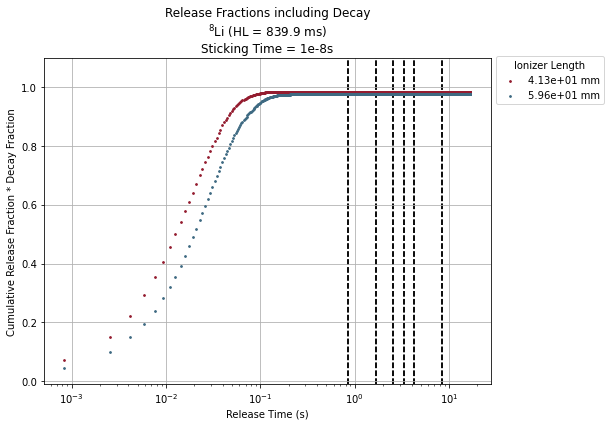

/var/folders/9n/nhtmq0l50ys2lvrp45z8vqbc0000gn/T/ipykernel_53244/1886460068.py:9: RuntimeWarning: overflow encountered in exp
  eff = C*(1-np.exp(-t/t1))*np.exp(-t/t2)
/var/folders/9n/nhtmq0l50ys2lvrp45z8vqbc0000gn/T/ipykernel_53244/1886460068.py:9: RuntimeWarning: overflow encountered in multiply
  eff = C*(1-np.exp(-t/t1))*np.exp(-t/t2)


Fit for 4.13e+01 mm (Samples = 7969) is,t_1 = 5.48e-04     +/- 2.20e-05 AND t_2 = 1.87e-02 +/- 1.82e-04
Fit for 5.96e+01 mm (Samples = 7969) is,t_1 = 5.73e-04     +/- 3.35e-05 AND t_2 = 2.91e-02 +/- 3.59e-04


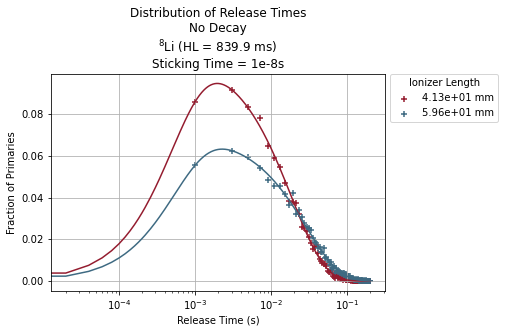

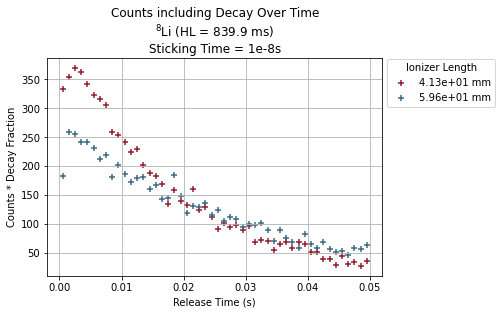

Maximum Release Fraction = 19.913%
Release Fraction at 1 half-life = 10.883%
Release Fraction at 2 half-lives = 16.003%
Release Fraction at 5 half-lives = 19.634%
Release Fraction at 10 half-lives = 19.909%
Maximum Release Fraction = 15.659%
Release Fraction at 1 half-life = 8.469%
Release Fraction at 2 half-lives = 12.391%
Release Fraction at 5 half-lives = 15.372%
Release Fraction at 10 half-lives = 15.654%


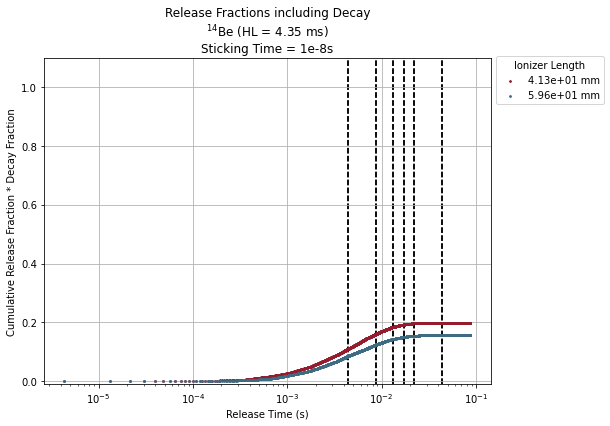

Fit for 4.13e+01 mm (Samples = 7969) is,t_1 = 6.05e-04     +/- 3.49e-05 AND t_2 = 2.43e-02 +/- 3.33e-04
Fit for 5.96e+01 mm (Samples = 7969) is,t_1 = 5.79e-04     +/- 4.22e-05 AND t_2 = 3.54e-02 +/- 5.05e-04


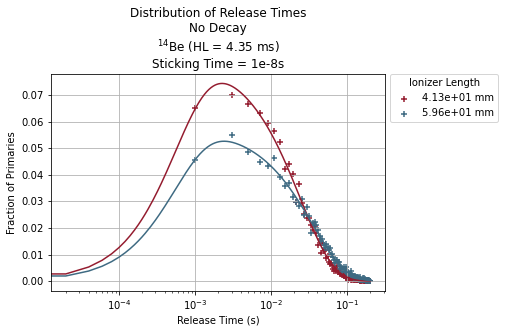

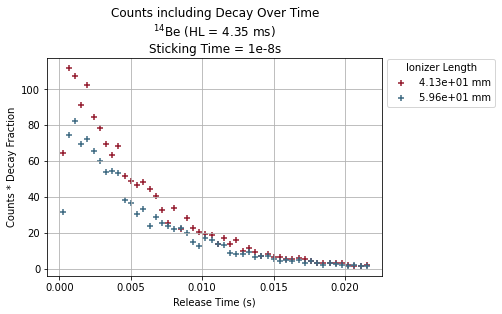

In [112]:
#making a directory to hold the plots
DIR = 'Plots/Arc/'
try: 
    os.mkdir(DIR)
except OSError as error:
    print(error) 
    if error.args[0] == 17:
        print('Directory already exists. Files may be overwritten if the same filenames are used.')

#lists of parameters for the plots
nuclides = [r'$^8$Li',r'$^{14}$Be']   #formatted labels/titles for nuclides
HL = [839.9e-3,4.35e-3]               #half-lives to feed into functions
HLC = ['839.9 ms','4.35 ms']          #half-lives for labels
col = ["#941c2f","#3e6a82","#656e85"] #colours
guess = []                            #initializing, should take tuples of 3 (C, t1, t2)
t1 = [4e-3,1e-4,1e-3,1e-3]            #guesses for t1 
t2 = [1e-2,1e-3,1e-2,3e-2]            #guesses for t2
domain = []                           #initializing, should take floats
dom = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-2] #this is really messy 
for tt1,tt2,dd in zip(t1,t2,dom):       #but I was looking at different ways of doing the domains
    guess.append((10,tt1,tt2))
    domain.append((dd/100,dd*1.5))
# domain[0] = (1e-8,1e-4)
# domain[-1] = (1e-5,5e-3)
    
#iterating over one parameter (each parameter gets a separate plot)
for idx,nn in enumerate(data.keys()):
    #setting up size of plot
    plt.figure(figsize=(8,6))
    
    #iterating over another parameter (each parameter gets a line on the plot)
    for idx2,ii in enumerate(data[nn].keys()): #keys() is a list of the dictionary keys rather than the values
        plot_combo(data[nn][ii]['tT']+data[nn][ii]['COL']*ts, #data: eff time + collisions*sticking time
                   t12=HL[idx],
                   label=ion_clean[idx2],
                   col=col[idx2],col2='#000000',bbin=10000,ctrl=False,line=True)

    #plotting commands
    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Cumulative Release Fraction * Decay Fraction')
    #plt.xlim(1e-8,0.2)
    plt.ylim(-0.01,1.1)
    plt.title('Release Fractions including Decay\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    #for legend:
      #loc is which part of the legend
      #bbox is the coordinates of where to place that part of the legend
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02)) 
    plt.grid(True,zorder=-1.0) #zorder gets the grid behind the lines/scatter plots
    #important! saving the file, with transparent background and dots/inch (resolution)
    plt.savefig(DIR+'cdecay-'+nn+'.png',bbox_inches='tight',dpi=400)
    #also important! this separates this plot from the plot generated in the next loop
      #it also gets the plot to show up in the output of this cell
    plt.show()
    
    
    #repeat the loop with whichever other functions you'd like to plot
    for idx2,ii in enumerate(data[nn].keys()):
        bbin = 100
        plot_hist(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,
                  label=ion_clean[idx2],col=col[idx2],mark=True,norm=True,
                  lin=10000,bbin=bbin,peak=False,guess=guess[idx2])#,domain=domain[idx2])

    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Fraction of Primaries')
    #plt.xlim(1e-7,1e-2)
    #plt.ylim(-0.01,10000)
    plt.title('Distribution of Release Times\nNo Decay\n'
              +nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'teff-ts-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    
    for idx2,ii in enumerate(data[nn].keys()):
        plot_decay(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,t12=HL[idx],
                              label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
                              col=col[idx2],col2=col[idx2],ctrl=False)

    #plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Counts * Decay Fraction')
    #plt.xlim(1e-8,0.2)
    #plt.ylim(-0.01,1.1)
    plt.title('Counts including Decay Over Time\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'decay-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    